In [16]:
from eeg_learn_functions import *

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [18]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [19]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [20]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [21]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [22]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = 100#Fs*frame_duration
    frames = []
    #steps = make_steps(len(df),frame_duration,overlap)

    frame = []
    for channel in df.columns:
        snippet = np.array(df.loc[:,int(channel)])
        f,Y =  get_fft(snippet)
        theta, alpha, beta = theta_alpha_beta_averages(f,Y)
        frame.append([theta, alpha, beta])
    frames.append(frame)
    return np.array(frames)

In [23]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [29]:
def make_data_pipeline(df,image_size):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = 100#Fs * frame_duration
    


    X_0 = make_frames(df,frame_duration)
    #steps = np.arange(0,len(df),frame_length)
    X_1 = X_0.reshape(len(X_0),14*3)

    images = gen_images(np.array(locs_2d),X_1, image_size, normalize=True)
    images = np.swapaxes(images, 1, 3) 
    X = images


    return X

In [50]:
df_0_train = pd.DataFrame(genfromtxt('data/data_0.csv', delimiter=',')).iloc[0:180000]
df_0_test = pd.DataFrame(genfromtxt('data/data_0.csv', delimiter=',')).iloc[180000:]
df_1_train = pd.DataFrame(genfromtxt('data/data_1.csv', delimiter=',')).iloc[0:175000]
df_1_test = pd.DataFrame(genfromtxt('data/data_1.csv', delimiter=',')).iloc[175000:]
df_0_train.to_csv('data/data_0_train.csv', index = False)
df_0_test.to_csv('data/data_0_test.csv', index = False)
df_1_train.to_csv('data/data_1_train.csv', index = False)
df_1_test.to_csv('data/data_1_test.csv', index = False)



In [41]:
file_names = ['data/data_0.csv',
              'data/data_1.csv']
labels = [1,0]
image_size = 28
frame_duration = 0.78
overlap = 0.0
X = make_data_pipeline(df,image_size)

In [38]:
X.shape

(1, 28, 28, 3)

In [39]:
y.shape

NameError: name 'y' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


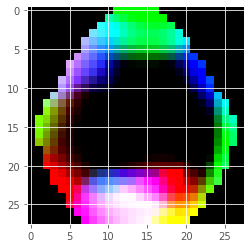

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[0])

In [298]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10,shuffle=True)

In [299]:
y_train.shape

(3600,)

In [300]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (3600, 28, 28, 3)
3600 train samples
401 test samples


In [301]:
np.mean(x_train)

0.0040877517

In [302]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = 2
epochs = 30

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



from sklearn.model_selection import KFold
# Let's train the model using RMSprop
kf = KFold(n_splits=10, shuffle = True)
acc_row = []
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['categorical_accuracy'])

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #x_train /= 255
    #x_test /= 255
    print(y_train)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.1)

    loss, acc = model.evaluate(x_test,  y_test, verbose=2)
    acc_row.append(acc)
res = pd.DataFrame(acc_row)
res

[1. 1. 1. ... 0. 0. 0.]
Train on 3240 samples, validate on 360 samples
Epoch 1/30
3240/3240 [==============================] - 2s 568us/step - loss: 0.6418 - categorical_accuracy: 0.6179 - val_loss: 0.5686 - val_categorical_accuracy: 0.7917
Epoch 2/30
3240/3240 [==============================] - 1s 431us/step - loss: 0.4686 - categorical_accuracy: 0.8519 - val_loss: 0.5229 - val_categorical_accuracy: 0.7444
Epoch 3/30
3240/3240 [==============================] - 1s 429us/step - loss: 0.3135 - categorical_accuracy: 0.9111 - val_loss: 0.7081 - val_categorical_accuracy: 0.6333
Epoch 4/30
3240/3240 [==============================] - ETA: 0s - loss: 0.2245 - categorical_accuracy: 0.93 - 1s 429us/step - loss: 0.2243 - categorical_accuracy: 0.9352 - val_loss: 0.6886 - val_categorical_accuracy: 0.7139
Epoch 5/30
3240/3240 [==============================] - 1s 429us/step - loss: 0.1721 - categorical_accuracy: 0.9485 - val_loss: 0.5940 - val_categorical_accuracy: 0.7639
Epoch 6/30
3240/3240 [===

Epoch 18/30
3240/3240 [==============================] - 1s 431us/step - loss: 0.0517 - categorical_accuracy: 0.9806 - val_loss: 1.1239 - val_categorical_accuracy: 0.8172
Epoch 19/30
3240/3240 [==============================] - 1s 429us/step - loss: 0.0551 - categorical_accuracy: 0.9818 - val_loss: 0.9377 - val_categorical_accuracy: 0.8837
Epoch 20/30
3240/3240 [==============================] - 1s 429us/step - loss: 0.0487 - categorical_accuracy: 0.9849 - val_loss: 1.2142 - val_categorical_accuracy: 0.8144
Epoch 21/30
3240/3240 [==============================] - 1s 430us/step - loss: 0.0543 - categorical_accuracy: 0.9840 - val_loss: 1.1669 - val_categorical_accuracy: 0.8116
Epoch 22/30
3240/3240 [==============================] - 1s 429us/step - loss: 0.0531 - categorical_accuracy: 0.9830 - val_loss: 0.8426 - val_categorical_accuracy: 0.8975
Epoch 23/30
3240/3240 [==============================] - 1s 430us/step - loss: 0.0465 - categorical_accuracy: 0.9824 - val_loss: 0.9249 - val_cat

Epoch 5/30
3240/3240 [==============================] - 1s 433us/step - loss: 0.1784 - categorical_accuracy: 0.9460 - val_loss: 0.4581 - val_categorical_accuracy: 0.8421
Epoch 6/30
3240/3240 [==============================] - 1s 435us/step - loss: 0.1455 - categorical_accuracy: 0.9565 - val_loss: 0.4868 - val_categorical_accuracy: 0.8421
Epoch 7/30
3240/3240 [==============================] - 1s 432us/step - loss: 0.1272 - categorical_accuracy: 0.9590 - val_loss: 0.9623 - val_categorical_accuracy: 0.6981
Epoch 8/30
3240/3240 [==============================] - 1s 429us/step - loss: 0.1085 - categorical_accuracy: 0.9633 - val_loss: 0.5584 - val_categorical_accuracy: 0.8421
Epoch 9/30
3240/3240 [==============================] - 1s 432us/step - loss: 0.0977 - categorical_accuracy: 0.9682 - val_loss: 0.6313 - val_categorical_accuracy: 0.8338
Epoch 10/30
3240/3240 [==============================] - 1s 429us/step - loss: 0.0879 - categorical_accuracy: 0.9682 - val_loss: 0.8153 - val_categori

3240/3240 [==============================] - 1s 450us/step - loss: 0.0914 - categorical_accuracy: 0.9682 - val_loss: 0.7846 - val_categorical_accuracy: 0.8476
Epoch 10/30
3240/3240 [==============================] - 1s 451us/step - loss: 0.0830 - categorical_accuracy: 0.9722 - val_loss: 0.8462 - val_categorical_accuracy: 0.8449
Epoch 11/30
3240/3240 [==============================] - ETA: 0s - loss: 0.0767 - categorical_accuracy: 0.97 - 1s 444us/step - loss: 0.0766 - categorical_accuracy: 0.9735 - val_loss: 1.3536 - val_categorical_accuracy: 0.7673
Epoch 12/30
3240/3240 [==============================] - 1s 444us/step - loss: 0.0720 - categorical_accuracy: 0.9762 - val_loss: 0.7435 - val_categorical_accuracy: 0.8753
Epoch 13/30
3240/3240 [==============================] - 1s 449us/step - loss: 0.0645 - categorical_accuracy: 0.9787 - val_loss: 1.0105 - val_categorical_accuracy: 0.8393
Epoch 14/30
3240/3240 [==============================] - 1s 440us/step - loss: 0.0604 - categorical_acc

3240/3240 [==============================] - 1s 440us/step - loss: 0.0730 - categorical_accuracy: 0.9756 - val_loss: 0.3445 - val_categorical_accuracy: 0.9280
Epoch 14/30
3240/3240 [==============================] - 1s 441us/step - loss: 0.0714 - categorical_accuracy: 0.9775 - val_loss: 0.7585 - val_categorical_accuracy: 0.8670
Epoch 15/30
3240/3240 [==============================] - 1s 443us/step - loss: 0.0695 - categorical_accuracy: 0.9772 - val_loss: 0.6529 - val_categorical_accuracy: 0.8809
Epoch 16/30
3240/3240 [==============================] - 1s 440us/step - loss: 0.0677 - categorical_accuracy: 0.9787 - val_loss: 0.8212 - val_categorical_accuracy: 0.8753
Epoch 17/30
3240/3240 [==============================] - 1s 441us/step - loss: 0.0567 - categorical_accuracy: 0.9809 - val_loss: 0.5652 - val_categorical_accuracy: 0.9030
Epoch 18/30
3240/3240 [==============================] - 1s 441us/step - loss: 0.0593 - categorical_accuracy: 0.9793 - val_loss: 0.7207 - val_categorical_acc

,0
0,0.9551
1,0.9750
2,0.9750
3,0.9725
4,0.9550
5,0.9650
6,0.9800
7,0.9800
8,0.9750
9,0.9675


In [210]:
model.evaluate(x_test, y_test)

801/801 [==============================] - 0s 307us/step


[0.2648034638013576, 0.9725343585014343]